In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Data cleaning tools
!pip install datacleaner
from datacleaner import autoclean

# Preprocessing and machine learning
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Visualization settings
%matplotlib inline


  Preparing metadata (setup.py) ... done
  Created wheel for datacleaner: filename=datacleaner-0.1.5-py3-none-any.whl size=7408 sha256=d70f49665de320f5ce535f6ceb7f6191369e71826c94132b5e00a6417b881eeb
  Stored in directory: /root/.cache/pip/wheels/8f/bc/5b/f7ca5772f61851334a8580f3ede175b92a7122eef3464e2b3d
Successfully built datacleaner


In [3]:
data = pd.read_csv("/content/churn_risk_train.csv")
data.drop(['Name','security_no'], inplace=True, axis=1)
data_clean = autoclean(data)
data_clean.head()

,customer_id,age,gender,region_category,membership_category,joining_date,days_since_joining,joined_through_referral,referral_id,preferred_offer_types,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,32243,18,0,2,3,939,2424,1,11358,1,...,300.63,53005.25,746,781.75,1,1,0,1,4,2
1,7055,32,0,0,4,975,2413,0,2225,1,...,306.34,12838.38,732,697.62,1,0,1,2,5,1
2,5910,44,0,1,2,193,2703,2,471,1,...,516.16,21027.00,779,500.69,0,1,1,3,3,5
3,32400,37,1,0,2,157,2716,2,5506,1,...,53.27,25239.56,1637,567.66,0,1,1,4,3,5
4,6070,31,0,0,2,1017,2398,1,11358,0,...,113.13,24483.66,743,663.06,0,1,1,2,3,5


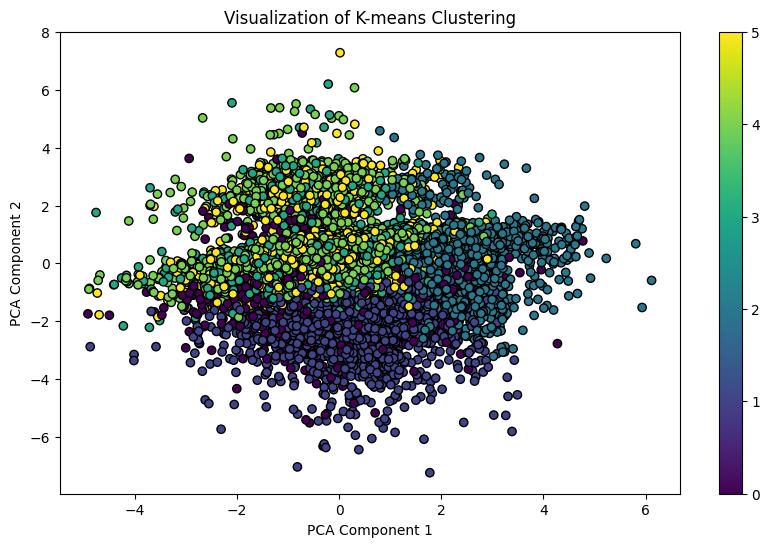

In [5]:
X = data_clean.drop(['customer_id','referral_id', 'churn_risk_score'], axis=1)  # Drop non-feature and target columns

# Converting integer-coded categorical features to strings
categorical_features = ['gender', 'region_category', 'membership_category', 'joined_through_referral',
                        'medium_of_operation', 'internet_option', 'used_special_discount',
                        'offer_application_preference', 'past_complaint', 'complaint_status', 'feedback']
X[categorical_features] = X[categorical_features].astype(str)

# Define preprocessing for numerical features
numeric_features = ['age', 'days_since_joining', 'days_since_last_login', 'avg_time_spent', 'avg_transaction_value', 'points_in_wallet']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Creating a column transformer to apply the transformations to the correct features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fitting and transforming the data
X_processed = preprocessor.fit_transform(X)

# Applying K-means clustering
kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(X_processed)
labels = kmeans.labels_

#PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c= labels, cmap='viridis', marker='o', edgecolor='k')
plt.colorbar()
plt.title('Visualization of K-means Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [6]:
# Calculating clustering metrics
silhouette = silhouette_score(X_processed, labels)
calinski_harabasz = calinski_harabasz_score(X_processed, labels)
davies_bouldin = davies_bouldin_score(X_processed, labels)
print(f"Silhouette Score: {silhouette}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")
print(f"Davies-Bouldin Index: {davies_bouldin}")

Silhouette Score: 0.07261035502092013
Calinski-Harabasz Index: 2219.734301596011
Davies-Bouldin Index: 2.6502204564155867


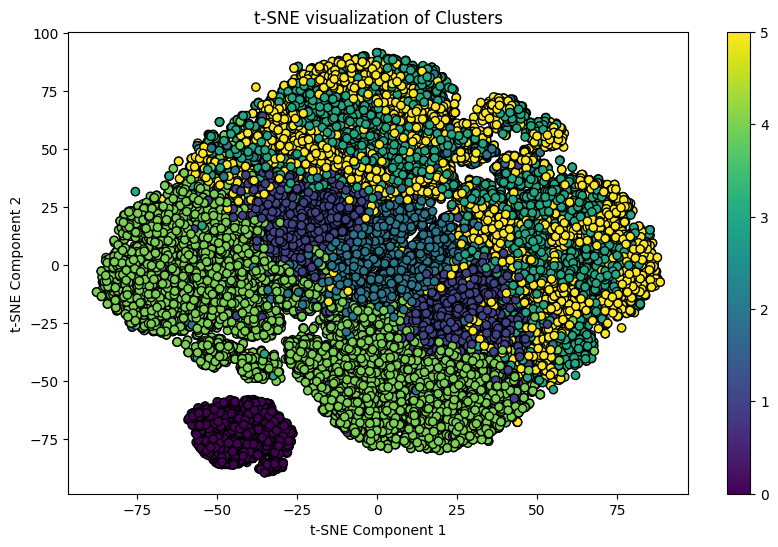

In [7]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_processed)
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k')
plt.colorbar()
plt.title('t-SNE visualization of Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()